In [235]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## TASK 1: Eigenfaces from training images

In [236]:
# provide path to train and test dir
train_dir = 'Eigenfaces/Train'
test_dir = 'Eigenfaces/Test'

In [237]:
# store images in list
train_images = []

for file in os.listdir(train_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(train_dir, file)
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        train_images.append(img_gray)     

In [238]:
h, w = train_images[0].shape
n_train_images = len(train_images)

### Preprocess and Display Images

In [239]:
def display_images(images):
    plt.figure(figsize = (15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(cv2.resize(images[i], (100, 100)), cmap = 'gray')

# removes variation in brightness and contrast
def preprocess(images):
    return [(img - np.mean(img))/np.std(img) for img in images]

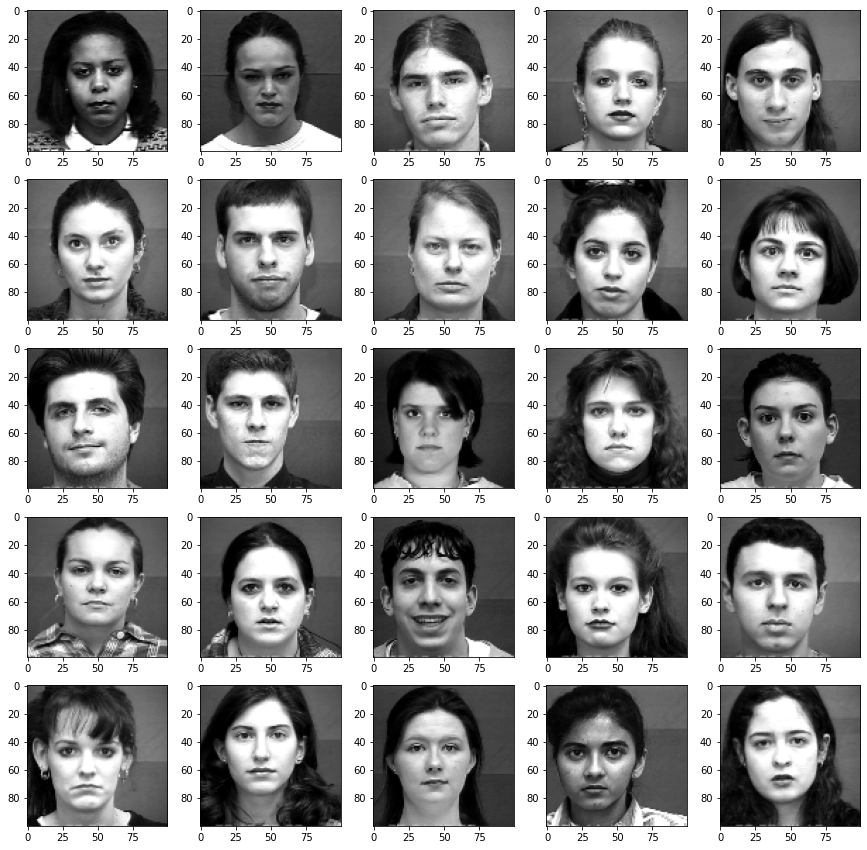

In [240]:
display_images(train_images)

### PCA for Training Images

In [241]:
# takes a list of training images and returns a list of eigenvectors and the mean face
'''
def get_eigenfaces(train_images):
    
    # initialize matrices to store eigenvalues and eigenvectors
    h, w = train_images[0].shape
    n = len(train_images)
    
    # center the data
    c = 1/n
    mean_face = c*train_images[0]
    for i in range(1,n):
        mean_face += c*train_images[i]
        
    mean_max, mean_min = np.max(mean_face), np.min(mean_face)    
    mean_face = np.clip(mean_face, mean_min, mean_max)
    centered_images = [(train_images[i] - mean_face) for i in range(n)]
    
    # flatten images and create data array
    data_arr = np.zeros((n, h*w))
    for i in range(n):
        data_arr[i, :] = np.ravel(centered_images[i]) 
    
    # compute eigenvalues and eigenvectors
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_arr, mean = mean_face.reshape(1, h*w))
    
    reshape_dim = int(np.sqrt(eigenvectors.shape[1]))
    eigenfaces = [eigenvectors[i,:].reshape((reshape_dim, reshape_dim)) for i in range(n)]

    return eigenfaces, mean.reshape(h,w), centered_images
'''


def get_eigenfaces(train_images):
    
    # initialize matrices to store eigenvalues and eigenvectors
    h, w = train_images[0].shape
    n = len(train_images)
    
    centered_images = preprocess(train_images)
    
    # flatten images and create data array
    data_arr = np.zeros((n, h*w))
    for i in range(n):
        data_arr[i, :] = np.ravel(centered_images[i]) 
    
    # compute eigenvalues and eigenvectors
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_arr, mean = None)
    
    reshape_dim = int(np.sqrt(eigenvectors.shape[1]))
    eigenfaces = [eigenvectors[i,:].reshape((reshape_dim, reshape_dim)) for i in range(n)]

    return eigenfaces, mean.reshape(h,w), centered_images

### Mean Face

In [242]:
eigenfaces, mean_face, centered_images = get_eigenfaces(train_images)

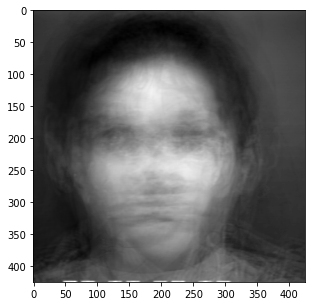

In [243]:
plt.figure(figsize = (5, 5))
plt.imshow(mean_face, cmap = 'gray')

### Eigenfaces

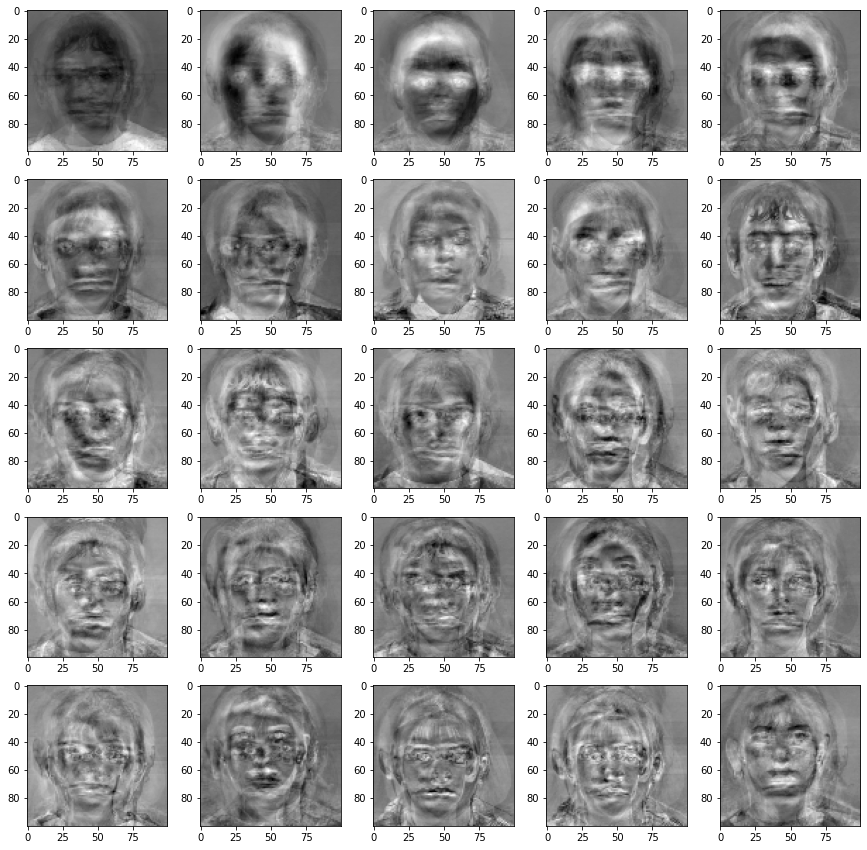

In [244]:
display_images(eigenfaces)

## TASK 2 : Reconstruction

### k = 2

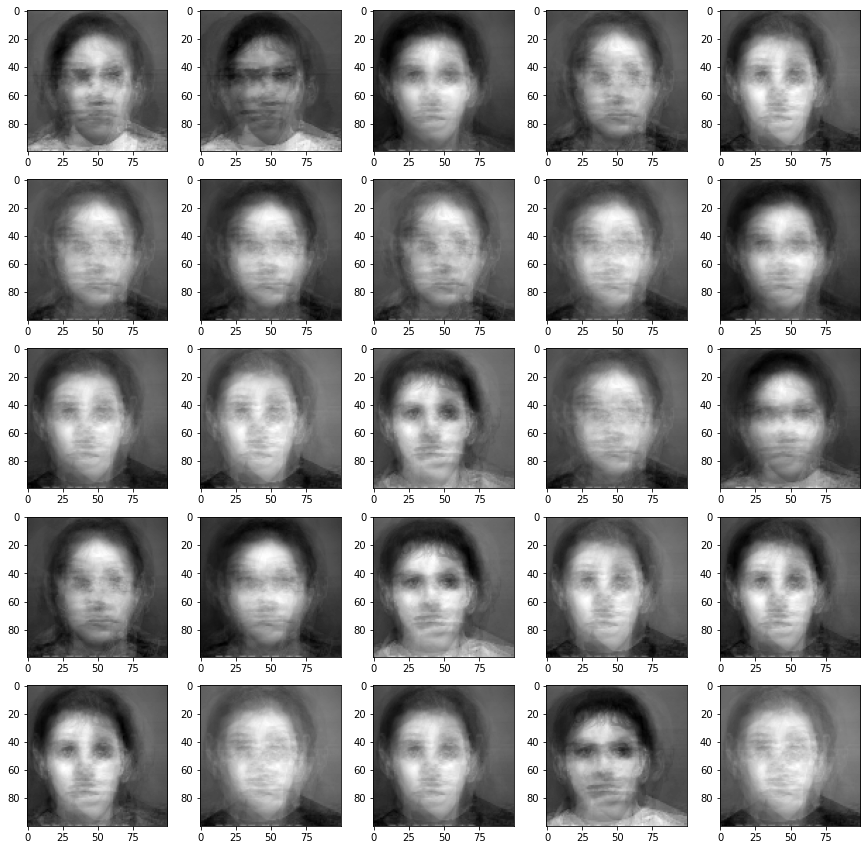

In [245]:
k = 2
projections = np.zeros((n_train_images, k))

# get projections
for i in range(k):
    for j in range(n_train_images):
        projections[j, i] = np.dot(centered_images[j].reshape(1, h*w), eigenfaces[i].reshape(h*w, 1))
        
# backprojection
backprojected_images = []
for i in range(n_train_images):
    img = np.zeros((h, w))
    for j in range(k):
        img += projections[i, j] * eigenfaces[j]
    # add average face
    img = img + mean_face
    backprojected_images.append(img)
    
display_images(backprojected_images)

### k = 5

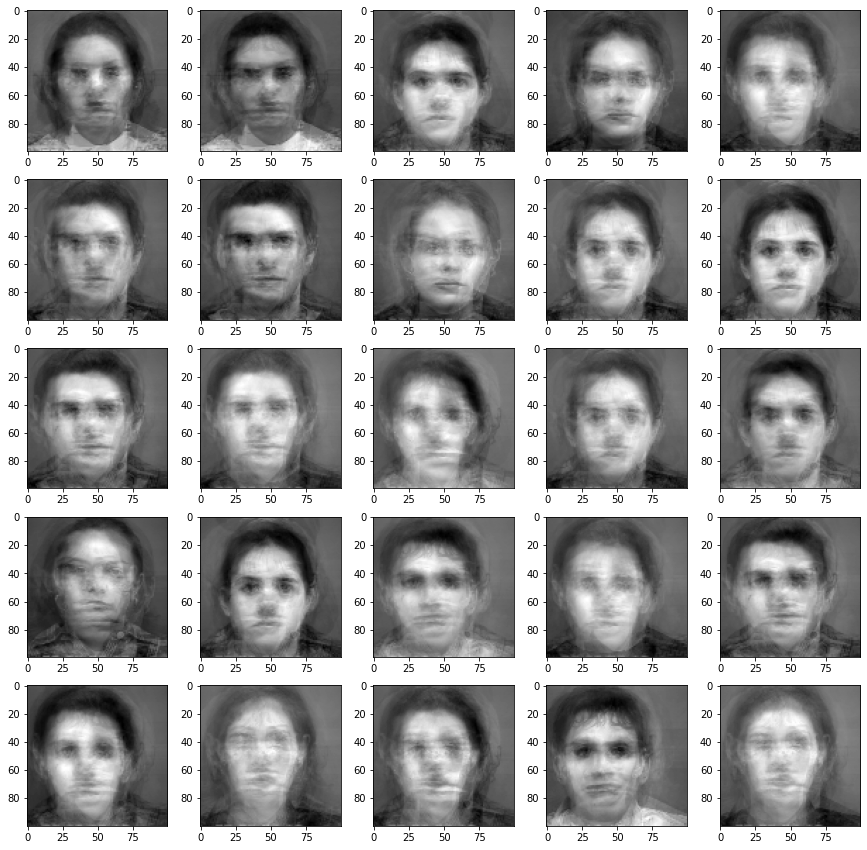

In [246]:
k = 5
projections = np.zeros((n_train_images, k))

# get projections
for i in range(k):
    for j in range(n_train_images):
        projections[j, i] = np.dot( centered_images[j].reshape(1, h*w), eigenfaces[i].reshape(h*w, 1))
        
# backprojection
backprojected_images = []
for i in range(n_train_images):
    img = np.zeros((h, w))
    for j in range(k):
        img += projections[i, j] * eigenfaces[j]
    # add average face
    img = img + mean_face
    backprojected_images.append(img)
    
display_images(backprojected_images)

### k = 15

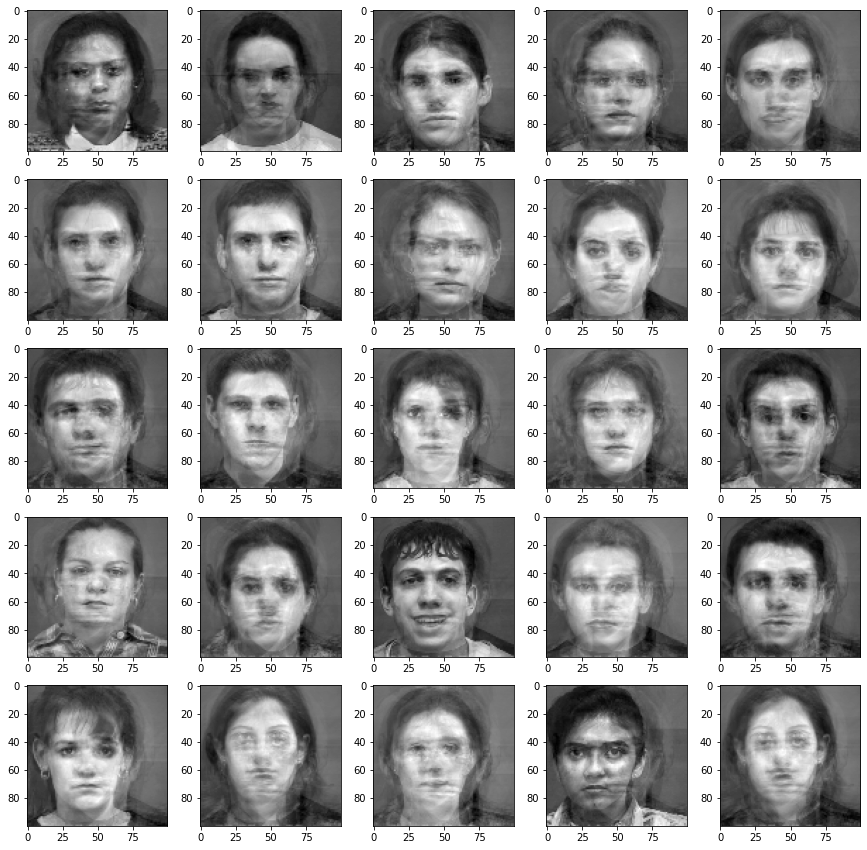

In [247]:
k = 15
projections = np.zeros((n_train_images, k))

# get projections
for i in range(k):
    for j in range(n_train_images):
        projections[j, i] = np.dot( centered_images[j].reshape(1, h*w), eigenfaces[i].reshape(h*w, 1))
        
# backprojection
backprojected_images = []
for i in range(n_train_images):
    img = np.zeros((h, w))
    for j in range(k):
        img += projections[i, j] * eigenfaces[j]
    # add average face
    img = img + mean_face
    backprojected_images.append(img)
    
display_images(backprojected_images)

# TASK 3: Detecting Face on Test Images

In [248]:
# load test images
test_images = []

for file in os.listdir(test_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(test_dir, file)
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_images.append(img_gray)

### Helper Functions

In [249]:
# returns reconstruction error for test image(sse)
def get_reconstrunction_error(img1, img2):
    return np.linalg.norm(img1 - img2)


# returns index of the closest training image
def get_closest_training_image(img):
    err = [np.linalg.norm(img - train_images[i]) for i in range(n_train_images)]
    return np.argmin(err)


# get backprojected image for a single image using 'k' eigenvectors
def get_backprojected_image(img, k):
    
    # get projection and reconstruction
    projections = np.zeros(k)
    for i in range(k):
        projections[i] = np.dot((img - mean_face).reshape(1, h*w), eigenfaces[i].reshape(h*w, 1))
        
    backprojected_img = np.zeros((h, w))
    for j in range(k):
        backprojected_img += projections[j] * eigenfaces[j]
        
    # add average face
    backprojected_img = backprojected_img + mean_face
    return backprojected_img


# display test and closest training images side to side
def display_images_side_by_size(closest_training_images):
    n_test_images = len(test_images)
    plt.figure(figsize = (5, 60))
    for i in range(n_test_images):
        plt.subplot(n_test_images, 2, i*2+1)
        plt.imshow(test_images[i], cmap = 'gray')
        plt.subplot(n_test_images, 2, i*2+2)
        plt.imshow(closest_training_images[i], cmap = 'gray')

        
def detect_faces(thresh, k):
    closest_training_images = []
    backprojected_images = []
    err = []
    for i, img in enumerate(test_images):
        backprojected_image = get_backprojected_image(img, k)
        reconstruction_err = get_reconstrunction_error(backprojected_image, img)
        if reconstruction_err <= thresh:
            closest_training_images.append(train_images[get_closest_training_image(img)])
        else:
            closest_training_images.append(np.zeros((h, w)))
        backprojected_images.append(backprojected_image)    
        err.append(reconstruction_err)
            
    return closest_training_images, backprojected_images, err

### k = 2

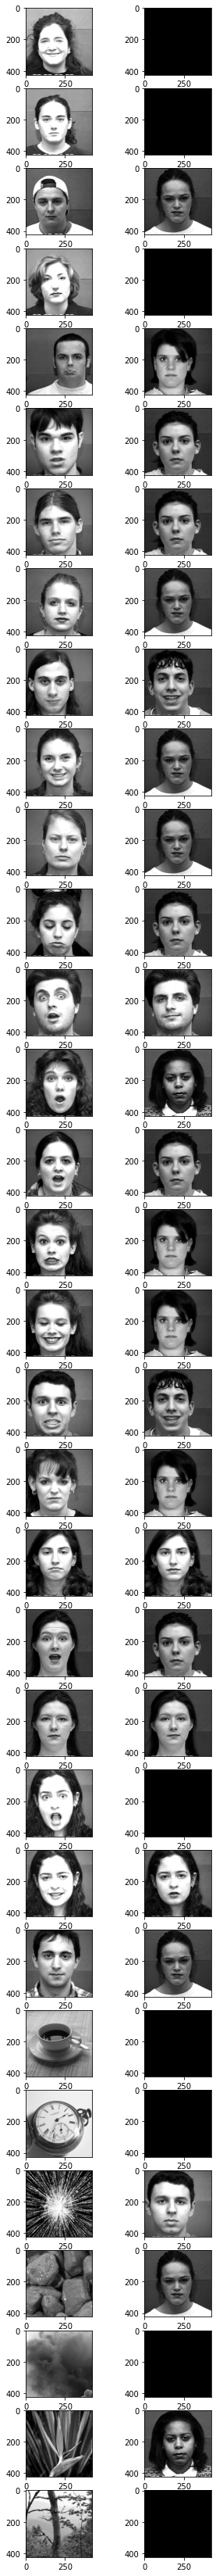

In [250]:
thresh = 60000
k = 2
closest_training_images, backprojected_images, err = detect_faces(thresh, k)
display_images_side_by_size(closest_training_images)

### k = 5

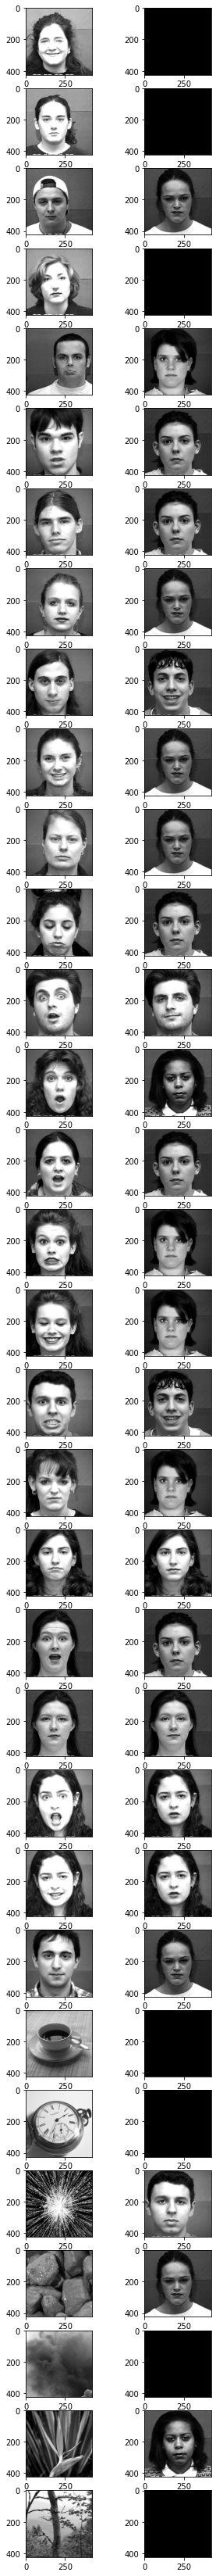

In [251]:
thresh = 60000
k = 5
closest_training_images, backprojected_images, err = detect_faces(thresh, k)
display_images_side_by_size(closest_training_images)

### k = 15

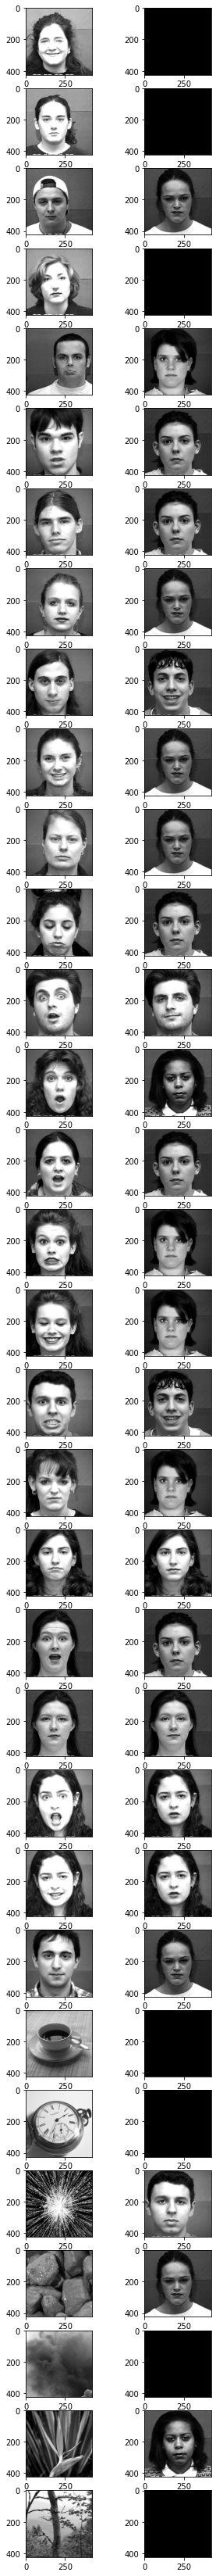

In [252]:
thresh = 60000
k = 15
closest_training_images, backprojected_images, err = detect_faces(thresh, k)
display_images_side_by_size(closest_training_images)